# Readout and Training

- This Notebook takes the annotated data
- Slices out a 3D data cube
- Tries to train a 3D-CNN

In [11]:
import yaml
import pandas as pd

annotation = pd.read_csv('F:/2022-08-24_session.txt', sep='\t')
annotation.columns = ['date', 'name','index','score']

In [12]:
with open('F:/2022-08-24_session.yaml') as f:
    metadata = yaml.safe_load(f)

In [13]:
metadata

{'annotation_file': '2022-08-24_session.txt',
 'file_raw': 'C:/Users/admin/Downloads/HeLa_Evosep_diaPASEF_RAW/60SPD_py8/20200428_Evosep_60SPD_SG06-16_MLHeLa_200ng_py8_S3-A4_1_2450.d',
 'file_results': 'F:/DIANN_Test/fdr_005/report.tsv',
 'hash_raw': '5a000a81aaed9bb749c83ec2a200c92b83d2c563cca3442664a13455d20427ae',
 'hash_results': 'f0b42fe56828e3e80bb4b80421e8edda00bc3389807521a118621cb76ffb0699',
 'tol_mob': 0.05,
 'tol_mz_ppm': 10,
 'tol_rt': 30,
 'ver_alphabase': '0.1.3',
 'ver_alphatims': '1.0.0'}

In [14]:
from utils import RawResults

In [15]:
c = RawResults(metadata['file_raw'], metadata['file_results'])

100%|██████████| 11864/11864 [00:03<00:00, 3161.46it/s]


In [16]:
import numpy as np
from tqdm import tqdm as tqdm

In [17]:
import scipy

In [18]:
im_size = 128

X = []
y = [] 

ions = ['prec']

for i in range(10):
    ions.append(f'b_{i+1}')
for i in range(11):
    ions.append(f'y_{i+1}')


for i in tqdm(range(len(annotation))):

    data_cube = []

    row = annotation.iloc[i]

    img_dict = c.img_from_index(row['index'], im_size)

    name = list(img_dict.keys())[0].split(' ')[1]

    for ion in ions:
        dict_name = ion+' '+name

        
        if dict_name in img_dict:

            to_add = img_dict[dict_name]

            if True:
                if len(data_cube) > 0: #Attempt to use correlations
                    to_add = scipy.signal.correlate2d(data_cube[0], to_add, mode='same')


            data_cube.append(to_add)
        else:
            data_cube.append(np.zeros((im_size, im_size)))
    
    X.append(np.stack(data_cube, axis=2))

    y.append(float(row['score'])>0)

    #y.append(float(row['score']))

100%|██████████| 561/561 [1:13:54<00:00,  7.90s/it]


In [30]:
im_size = 128

y = [] 

ions = ['prec']

for i in range(10):
    ions.append(f'b_{i+1}')
for i in range(11):
    ions.append(f'y_{i+1}')


for i in tqdm(range(len(annotation))):

    data_cube = []
    row = annotation.iloc[i]
    y.append(float(row['score']))

    #y.append(float(row['score']))

100%|██████████| 561/561 [00:00<00:00, 7043.28it/s]


In [20]:
import matplotlib.pyplot as plt

In [21]:
X = np.array(X)
y = np.array(y)

In [33]:
np.savez('training_data.npz',X=X,y=y)

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


In [24]:

if False:
  num_classes = 1


  model = Sequential([
    layers.Rescaling(1./255, input_shape=(im_size, im_size, X.shape[-1])),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
  ])

  model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])

  model.summary()

num_classes = 1


model = Sequential([
  layers.Rescaling(1./255, input_shape=(im_size, im_size, X.shape[-1])),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dropout(0.5),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='linear')
])

model.compile(optimizer='adam',
              loss="mean_absolute_percentage_error",
              metrics=['accuracy', 'mae','mape'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 22)      0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      3184      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        1

In [25]:

if True:
    inputs = keras.Input((im_size, im_size, X.shape[-1], 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    #x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    #x = layers.MaxPool3D(pool_size=2)(x)
    #x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")


    model.summary()

    model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])

    model.summary()



if True:
    inputs = keras.Input((im_size, im_size, X.shape[-1], 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    #x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    #x = layers.MaxPool3D(pool_size=2)(x)
    #x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="linear")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")


    model.summary()

    model.compile(optimizer='adam',
                loss="mean_absolute_percentage_error",
                metrics=['accuracy', 'mae','mape'])

    model.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 22, 1)  0         
                             ]                                   
                                                                 
 conv3d (Conv3D)             (None, 126, 126, 20, 64)  1792      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 63, 63, 10, 64)   0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 63, 63, 10, 64)   256       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 61, 61, 8, 64)     110656    
                                                             

In [26]:
epochs=20
history = model.fit(
  x = X_train,
  y = y_train,
  validation_data=(X_test, y_test),
  epochs=epochs,
  batch_size=64,
)


Epoch 1/20
6/6 [==============================] - 724s 120s/step - loss: 17489158.0000 - accuracy: 0.0933 - mae: 0.5713 - mape: 17489158.0000 - val_loss: 72567224.0000 - val_accuracy: 0.0430 - val_mae: 5.7678 - val_mape: 72567224.0000
Epoch 2/20
6/6 [==============================] - 723s 120s/step - loss: 24591122.0000 - accuracy: 0.0933 - mae: 0.6673 - mape: 24591122.0000 - val_loss: 40776488.0000 - val_accuracy: 0.0430 - val_mae: 3.6098 - val_mape: 40776488.0000
Epoch 3/20
6/6 [==============================] - 724s 120s/step - loss: 18672864.0000 - accuracy: 0.0987 - mae: 0.6135 - mape: 18672864.0000 - val_loss: 13785640.0000 - val_accuracy: 0.0430 - val_mae: 1.5392 - val_mape: 13785640.0000
Epoch 4/20
6/6 [==============================] - 723s 120s/step - loss: 14711562.0000 - accuracy: 0.1013 - mae: 0.5815 - mape: 14711562.0000 - val_loss: 3042634.0000 - val_accuracy: 0.0753 - val_mae: 0.7577 - val_mape: 3042634.0000
Epoch 5/20
6/6 [==============================] - 723s 120s/st

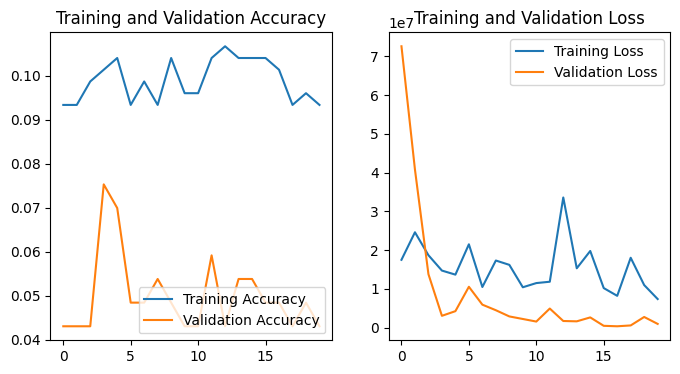

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [28]:
y_hat = model.predict(X_test)

6/6 [==============================] - 10s 2s/step


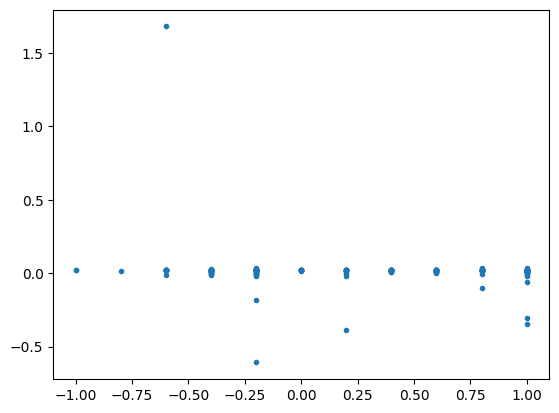

In [29]:
plt.plot(y_test, y_hat, '.')